In [6]:
from tensorflow import keras
import numpy as np
import pandas 
import matplotlib.pyplot as plt
import tensorflow as tf

# 把python函数转化为tensorflow中的函数

In [2]:
# tensorflow中的代码做了优化, 运行速度会快一些.
# elu z > 0 ? scale * z : scale * alpha * tf.nn.elu()
# selu
def scaled_elu(z, scale=1.0, alpha=1.0):
    is_positive = tf.greater_equal(z, 0.0)
    # np.where
    return scale * tf.where(is_positive, z, alpha * tf.nn.elu(z))

In [7]:
# 标量
print(scaled_elu(tf.constant(-3.)))

tf.Tensor(-0.95021296, shape=(), dtype=float32)


In [8]:
# 向量
print(scaled_elu(tf.constant([-3., -2.5])))

tf.Tensor([-0.95021296 -0.917915  ], shape=(2,), dtype=float32)


In [9]:
scaled_elu_tf = tf.function(scaled_elu)

In [10]:
scaled_elu_tf

In [11]:
print(scaled_elu_tf(tf.constant(-3.)))
print(scaled_elu_tf(tf.constant([-3., -2.5])))

tf.Tensor(-0.95021296, shape=(), dtype=float32)
tf.Tensor([-0.95021296 -0.917915  ], shape=(2,), dtype=float32)


In [12]:
%timeit scaled_elu(tf.random.normal((1000, 1000)))
%timeit scaled_elu_tf(tf.random.normal((1000, 1000)))

25.3 ms ± 2.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
21 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
scaled_elu_tf.python_function is scaled_elu

True

In [14]:
# tf.function装饰器的写法
# 1 + 1/2 + 1/2^2 + 1/ 2^3 + ... + 1/2^n  = 2

@tf.function
def converge_to_2(n_iters):
    total = tf.constant(0.)
    increment = tf.constant(1.)
    for _ in range(n_iters):
        total += increment
        increment /= 2.0
    return total

In [15]:
converge_to_2

In [16]:
converge_to_2(28)

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

In [17]:
# 展示tensorflow内部计算代码
def display_tf_code(func):
    code = tf.autograph.to_code(func)
    from IPython.display import display, Markdown
    display(Markdown('```python\n{}\n```'.format(code)))

In [18]:
display_tf_code(scaled_elu)

```python
def tf__scaled_elu(z, scale=None, alpha=None):
    with ag__.FunctionScope('scaled_elu', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        is_positive = ag__.converted_call(ag__.ld(tf).greater_equal, (ag__.ld(z), 0.0), None, fscope)
        try:
            do_return = True
            retval_ = ag__.ld(scale) * ag__.converted_call(ag__.ld(tf).where, (ag__.ld(is_positive), ag__.ld(z), ag__.ld(alpha) * ag__.converted_call(ag__.ld(tf).nn.elu, (ag__.ld(z),), None, fscope)), None, fscope)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

```

In [19]:
display_tf_code(converge_to_2.python_function)

```python
def tf__converge_to(n_iters):
    with ag__.FunctionScope('converge_to_2', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        total = ag__.converted_call(ag__.ld(tf).constant, (0.0,), None, fscope)
        increment = ag__.converted_call(ag__.ld(tf).constant, (1.0,), None, fscope)

        def get_state():
            return (total, increment)

        def set_state(vars_):
            nonlocal total, increment
            (total, increment) = vars_

        def loop_body(itr):
            nonlocal total, increment
            _ = itr
            total = ag__.ld(total)
            total += increment
            increment = ag__.ld(increment)
            increment /= 2.0
        _ = ag__.Undefined('_')
        ag__.for_stmt(ag__.converted_call(ag__.ld(range), (ag__.ld(n_iters),), None, fscope), None, loop_body, get_state, set_state, ('total', 'increment'), {'iterate_names': '_'})
        try:
            do_return = True
            retval_ = ag__.ld(total)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

```

In [20]:
# 函数操作的是tensorflow的变量, 那么要把变量定义在函数外面.
var = tf.Variable(0.)

@tf.function
def add_21():
    return var.assign_add(21) # 21
print(add_21())

tf.Tensor(21.0, shape=(), dtype=float32)


In [21]:
# 通过tf.function的签名来规定输入参数的数据类型
@ tf.function(input_signature=[tf.TensorSpec([None], tf.float32, name='x')])
def cube(z):
    return tf.pow(z, 3)

In [25]:
cube(tf.constant([1.1,2.2,3.3]))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 1.3310001, 10.648001 , 35.936996 ], dtype=float32)>

In [26]:
# get_concrete_function --> SavedModel
cube_func_float32 = cube.get_concrete_function(tf.TensorSpec([None], tf.float32))
print(cube_func_float32)

ConcreteFunction cube(z)
  Args:
    z: float32 Tensor, shape=(None,)
  Returns:
    float32 Tensor, shape=(None,)


In [27]:
cube_func_float32.graph

In [28]:
cube_func_float32.graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Pow/y' type=Const>,
 <tf.Operation 'Pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [29]:
pow_op = cube_func_float32.graph.get_operations()[2]

In [30]:
print(pow_op)

name: "Pow"
op: "Pow"
input: "x"
input: "Pow/y"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}



In [31]:
print(list(pow_op.inputs))

[<tf.Tensor 'x:0' shape=(None,) dtype=float32>, <tf.Tensor 'Pow/y:0' shape=() dtype=float32>]


In [32]:
print(list(pow_op.outputs))

[<tf.Tensor 'Pow:0' shape=(None,) dtype=float32>]


In [33]:
cube_func_float32.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [34]:
cube_func_float32.graph.as_graph_def()

node {
  name: "x"
  op: "Placeholder"
  attr {
    key: "_user_specified_name"
    value {
      s: "x"
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
node {
  name: "Pow/y"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
        }
        float_val: 3.0
      }
    }
  }
}
node {
  name: "Pow"
  op: "Pow"
  input: "x"
  input: "Pow/y"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
}
node {
  name: "Identity"
  op: "Identity"
  input: "Pow"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
}
versions {
  producer: 1087
}

# 自定义损失函数

In [35]:
from sklearn.datasets import fetch_california_housing

In [41]:
housing = fetch_california_housing()
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [42]:
print(housing.target)

[4.526 3.585 3.521 ... 0.923 0.847 0.894]


In [43]:
housing.data.shape

(20640, 8)

In [44]:
# 切割数据
# 训练数据, 验证集, 测试数据
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state=7)
# 从x_train_all中切割出训练数据和校验数据
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [45]:
# 标准化处理
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [46]:
x_train.shape

(11610, 8)

In [47]:
# 定义网络
model = keras.models.Sequential([
    # input_dim, input_shape一定要是元组
    keras.layers.Dense(32, activation='relu', input_shape=x_train.shape[1:]),
    keras.layers.Dense(1)
])

In [48]:
x_train.shape[1:]

(8,)

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [52]:
32*8 +32

288

In [53]:
32*1+1

33

In [54]:
# 自定义损失函数
def customized_mse(y_true,y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))
model.compile(loss=customized_mse,optimizer='sgd',metrics=[customized_mse])

In [55]:
callbacks = []
history = model.fit(x_train_scaled, y_train, 
          validation_data=(x_valid_scaled, y_valid), 
          epochs=20)

Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 0.7608 - customized_mse: 0.7608 - val_loss: 0.7033 - val_customized_mse: 0.7032
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 1.1336 - customized_mse: 1.1332 - val_loss: 0.5357 - val_customized_mse: 0.5356
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4442 - customized_mse: 0.4441 - val_loss: 0.4422 - val_customized_mse: 0.4421
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4109 - customized_mse: 0.4110 - val_loss: 0.4178 - val_customized_mse: 0.4178
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3960 - customized_mse: 0.3962 - val_loss: 0.4160 - val_customized_mse: 0.4159
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3893 - customized_mse: 0.3893 - val_loss: 0.4010 - val_customized_mse: 0.4010
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.

In [56]:
history.history

{'loss': [0.7608385682106018,
  1.1336361169815063,
  0.44415318965911865,
  0.4109194278717041,
  0.39597195386886597,
  0.38927534222602844,
  0.384023517370224,
  0.3766297399997711,
  0.373050332069397,
  0.3680110275745392,
  0.36512675881385803,
  0.36257052421569824,
  0.3582809865474701,
  0.35622599720954895,
  0.35500115156173706,
  0.3551100492477417,
  0.3504903316497803,
  0.34864330291748047,
  0.3470538556575775,
  0.34452444314956665],
 'customized_mse': [0.7607795000076294,
  1.1332389116287231,
  0.4440617561340332,
  0.4110241234302521,
  0.39616915583610535,
  0.3893277049064636,
  0.3840283155441284,
  0.37663331627845764,
  0.37294745445251465,
  0.3679792881011963,
  0.3654951751232147,
  0.3625240623950958,
  0.35827961564064026,
  0.35609060525894165,
  0.35509514808654785,
  0.35507071018218994,
  0.350525826215744,
  0.3486345708370209,
  0.3471069633960724,
  0.344564825296402],
 'val_loss': [0.7033477425575256,
  0.5357256531715393,
  0.44220659136772156,
 

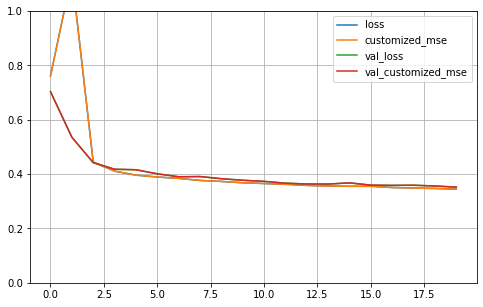

In [57]:
# 定义画图的函数
def plot_learning_curves(history):
    pandas.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

# 微分

In [77]:
# 3 * x^2 + 2 * x - 1
# 手动微分
def f(x):
    return 3. * x ** 2 + 2. * x - 1.

# 近似求导
def approximate_derivative(f, x, eps=1e-3):
    return (f(x + eps) - f(x - eps)) / (2. * eps)

In [78]:
print(approximate_derivative(f, 1.))

7.999999999999119


In [79]:
# 两个未知数, 求偏导
def g(x1, x2):
    return (x1 + 5) * (x2 ** 2)

# 分别求g对x1,和x2的偏导.
def approximate_gradient(g, x1, x2, eps=1e-3):
    dg_x1 = approximate_derivative(lambda x: g(x, x2), x1, eps)
    dg_x2 = approximate_derivative(lambda x: g(x1, x), x2, eps)
    return dg_x1, dg_x2

In [80]:
approximate_gradient(g, 2, 3)

(8.999999999993236, 41.999999999994486)

In [81]:
# tf.GradientTape来求导.
x1 = tf.Variable(2.0)
x2 = tf.Variable(3.0)

with tf.GradientTape() as tape:
    z = g(x1, x2)

dz_x1 = tape.gradient(z, x1)
print(dz_x1)
# tape只能用一次. 
dz_x2 = tape.gradient(z, x2)

tf.Tensor(9.0, shape=(), dtype=float32)


RuntimeError: A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)

## persistent=True

In [82]:
x1 = tf.Variable(2.0)
x2 = tf.Variable(3.0)

with tf.GradientTape(persistent=True) as tape:
    z = g(x1, x2)

dz_x1 = tape.gradient(z, x1)
dz_x2 = tape.gradient(z, x2)
print(dz_x1, dz_x2)
# 用完之后, 手动释放tape的内存
del tape

tf.Tensor(9.0, shape=(), dtype=float32) tf.Tensor(42.0, shape=(), dtype=float32)


In [83]:
# 常量求导
x1 = tf.constant(2.0)
x2 = tf.constant(3.0)

with tf.GradientTape() as tape:
    tape.watch(x1)
    tape.watch(x2)
    z = g(x1, x2)
    
# 默认是不会对常量求导.
dz_x1x2 = tape.gradient(z, [x1, x2])
print(dz_x1x2)

[<tf.Tensor: shape=(), dtype=float32, numpy=9.0>, <tf.Tensor: shape=(), dtype=float32, numpy=42.0>]


In [85]:
from tensorflow import keras

In [84]:
# 结合optimizer去实现梯度下降
learing_rate = 0.1
x = tf.Variable(0.0)
optimizer = keras.optimizers.SGD(lr=learing_rate)

for _ in range(100):
    with tf.GradientTape() as tape:
        z = f(x)
    dz_dx = tape.gradient(z, x)
#     x.assign_sub(learing_rate * dz_dx) # x -= learning_rate * dz_dx
    optimizer.apply_gradients([(dz_dx, x)])
print(x)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.3333333>


C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


# 自定义layer

In [61]:
housing = fetch_california_housing()
# 切割数据
# 训练数据, 验证集, 测试数据
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state=7)
# 从x_train_all中切割出训练数据和校验数据
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

# 标准化处理
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [62]:
# 自定义layer
class CustomizedDenseLayer(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        self.units = units
        self.activation = keras.layers.Activation(activation)
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        """构建所需要的参数"""
        # None, 8  @  w  + b
        # w  * x + b
        self.kernel = self.add_weight(name='kernel',
                       shape=(input_shape[1], self.units),
                       initializer='uniform',
                       trainable=True)
        self.bias = self.add_weight(name='bias',
                       shape=(self.units,),
                       initializer='zeros',
                       trainable=True)
        super().build(input_shape)
        
    def call(self, x):
        """完成正向传播"""
        return self.activation(x @ self.kernel + self.bias)

In [63]:
# 通过lambda函数快速自定义层次
# softplus : log(1 + e^x)
customized_softplus = keras.layers.Lambda(lambda x: tf.nn.softplus(x))

In [64]:
customized_softplus

In [65]:
customized_softplus([-10., -5., 0., 5., 10.])

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([4.5398898e-05, 6.7153489e-03, 6.9314718e-01, 5.0067153e+00,
       1.0000046e+01], dtype=float32)>

In [66]:
# 定义网络
model = keras.models.Sequential([
    # input_dim, input_shape一定要是元组
    # input_shape=(None, 8)
    # input_shape=(8,)
    CustomizedDenseLayer(32, input_shape=x_train.shape[1:]),
    customized_softplus,
    CustomizedDenseLayer(1)
])

In [67]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 customized_dense_layer (Cus  (None, 32)               288       
 tomizedDenseLayer)                                              
                                                                 
 lambda (Lambda)             (None, 32)                0         
                                                                 
 customized_dense_layer_1 (C  (None, 1)                33        
 ustomizedDenseLayer)                                            
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [68]:
# 配置
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mse'])

In [69]:
callbacks = []
history = model.fit(x_train_scaled, y_train, 
          validation_data=(x_valid_scaled, y_valid), 
          epochs=20)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 0.9702 - mse: 0.9702 - val_loss: 0.7008 - val_mse: 0.7008
Epoch 2/20
363/363 [==============================] - 0s 932us/step - loss: 0.6335 - mse: 0.6335 - val_loss: 0.6581 - val_mse: 0.6581
Epoch 3/20
363/363 [==============================] - 0s 938us/step - loss: 0.5916 - mse: 0.5916 - val_loss: 0.6191 - val_mse: 0.6191
Epoch 4/20
363/363 [==============================] - 0s 910us/step - loss: 0.5571 - mse: 0.5571 - val_loss: 0.5781 - val_mse: 0.5781
Epoch 5/20
363/363 [==============================] - 0s 944us/step - loss: 0.5279 - mse: 0.5279 - val_loss: 0.5493 - val_mse: 0.5493
Epoch 6/20
363/363 [==============================] - 0s 940us/step - loss: 0.5086 - mse: 0.5086 - val_loss: 0.5319 - val_mse: 0.5319
Epoch 7/20
363/363 [==============================] - 0s 939us/step - loss: 0.4953 - mse: 0.4953 - val_loss: 0.5216 - val_mse: 0.5216
Epoch 8/20
363/363 [==============================] - 0s 933us/s

In [70]:
history.history

{'loss': [0.970180094242096,
  0.6334768533706665,
  0.5916064977645874,
  0.5571306347846985,
  0.527895987033844,
  0.5086361169815063,
  0.4952961504459381,
  0.4849610924720764,
  0.47910115122795105,
  0.47328928112983704,
  0.468534380197525,
  0.46578213572502136,
  0.4601820409297943,
  0.4577215313911438,
  0.4543205499649048,
  0.4511111378669739,
  0.4492746889591217,
  0.4478296637535095,
  0.44533082842826843,
  0.4437219202518463],
 'mse': [0.970180094242096,
  0.6334768533706665,
  0.5916064977645874,
  0.5571306347846985,
  0.527895987033844,
  0.5086361169815063,
  0.4952961504459381,
  0.4849610924720764,
  0.47910115122795105,
  0.47328928112983704,
  0.468534380197525,
  0.46578213572502136,
  0.4601820409297943,
  0.4577215313911438,
  0.4543205499649048,
  0.4511111378669739,
  0.4492746889591217,
  0.4478296637535095,
  0.44533082842826843,
  0.4437219202518463],
 'val_loss': [0.7007525563240051,
  0.6580983996391296,
  0.6190933585166931,
  0.5781125426292419,
 

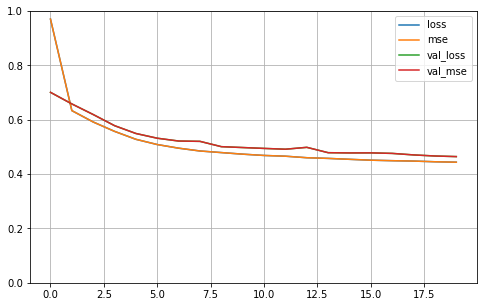

In [71]:
# 定义画图的函数
def plot_learning_curves(history):
    pandas.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

# 手动实现训练过程

In [86]:
# 1. 遍历数据集
    # 自动求导
# 2. epoch, 验证集

epochs = 20
batch_size = 32
steps_per_epoch = len(x_train_scaled) // batch_size
optimizer = keras.optimizers.SGD()
metric = keras.metrics.MeanSquaredError()

def random_batch(x, y, batch_size=32):
    idx = np.random.randint(0, len(x), size=batch_size)
    return x[idx], y[idx]

model = keras.models.Sequential([
    # input_dim, input_shape一定要是元组
    keras.layers.Dense(32, activation='relu', input_shape=x_train.shape[1:]),
    keras.layers.Dense(1)
])

for epoch in range(epochs):
    # 每次epoch需要重置评估指标
    metric.reset_states()
    for step in range(steps_per_epoch):
        x_batch, y_batch = random_batch(x_train_scaled, y_train, batch_size)
        
        with tf.GradientTape() as tape:
            y_pred = model(x_batch)
            y_pred = tf.squeeze(y_pred, 1)
            # 计算损失
            loss = keras.losses.mean_squared_error(y_batch, y_pred)
            metric(y_batch, y_pred)
            
        # 计算损失函数中参数的梯度
        grads = tape.gradient(loss, model.variables)
        # 更新
        grads_and_vars = zip(grads, model.variables)
        optimizer.apply_gradients(grads_and_vars)
        print('Epoch:', epoch, 'train_mse:', metric.result().numpy(), end='')
        
    # 每个epoch去计算一下校验集的效果
    y_valid_pred = model(x_valid_scaled)
    y_valid_pred = tf.squeeze(y_valid_pred, 1)
    valid_loss = keras.losses.mean_squared_error(y_valid, y_valid_pred)
    print('\t', 'valid mse:', valid_loss.numpy())

Epoch: 0 train_mse: 5.326661Epoch: 0 train_mse: 5.4018173Epoch: 0 train_mse: 5.2168818Epoch: 0 train_mse: 4.6488667Epoch: 0 train_mse: 4.4494543Epoch: 0 train_mse: 4.5249896Epoch: 0 train_mse: 4.243942Epoch: 0 train_mse: 4.007749Epoch: 0 train_mse: 3.7886865Epoch: 0 train_mse: 3.5789707Epoch: 0 train_mse: 3.4308393Epoch: 0 train_mse: 3.3094673Epoch: 0 train_mse: 3.192647Epoch: 0 train_mse: 3.0462005Epoch: 0 train_mse: 2.9002557Epoch: 0 train_mse: 2.8133276Epoch: 0 train_mse: 2.6994214Epoch: 0 train_mse: 2.6466913Epoch: 0 train_mse: 2.582011Epoch: 0 train_mse: 2.510765Epoch: 0 train_mse: 2.453283Epoch: 0 train_mse: 2.4336183Epoch: 0 train_mse: 2.383826Epoch: 0 train_mse: 2.3323743Epoch: 0 train_mse: 2.2890887Epoch: 0 train_mse: 2.2451634Epoch: 0 train_mse: 2.194518Epoch: 0 train_mse: 2.1456785Epoch: 0 train_mse: 2.0994847Epoch: 0 train_mse: 2.064465Epoch: 0 train_mse: 2.024088Epoch: 0 train_mse: 1.9827579Epoch: 0 train_mse: 1.94672Epoch: 0 train_mse: 1.9161588Epoch: 0 train_mse: 1.87858

Epoch: 0 train_mse: 0.8491531Epoch: 0 train_mse: 0.8477341Epoch: 0 train_mse: 0.84676206Epoch: 0 train_mse: 0.8452175Epoch: 0 train_mse: 0.8431354Epoch: 0 train_mse: 0.8427355Epoch: 0 train_mse: 0.84107465Epoch: 0 train_mse: 0.84093887Epoch: 0 train_mse: 0.83919835Epoch: 0 train_mse: 0.83720785Epoch: 0 train_mse: 0.83526045Epoch: 0 train_mse: 0.83372194Epoch: 0 train_mse: 0.83201617Epoch: 0 train_mse: 0.83225876Epoch: 0 train_mse: 0.8319123Epoch: 0 train_mse: 0.8309394Epoch: 0 train_mse: 0.82919455Epoch: 0 train_mse: 0.8280685Epoch: 0 train_mse: 0.8265116Epoch: 0 train_mse: 0.8257319Epoch: 0 train_mse: 0.82613236Epoch: 0 train_mse: 0.82520676Epoch: 0 train_mse: 0.82428086Epoch: 0 train_mse: 0.82297015Epoch: 0 train_mse: 0.82163334Epoch: 0 train_mse: 0.82009876Epoch: 0 train_mse: 0.8193658Epoch: 0 train_mse: 0.81806296Epoch: 0 train_mse: 0.8163586Epoch: 0 train_mse: 0.81591386Epoch: 0 train_mse: 0.81473976Epoch: 0 train_mse: 0.8139809Epoch: 0 train_mse: 0.8129771Epoch: 0 train_mse: 0.81

Epoch: 1 train_mse: 0.37639928Epoch: 1 train_mse: 0.5238569Epoch: 1 train_mse: 0.49002063Epoch: 1 train_mse: 0.46154752Epoch: 1 train_mse: 0.5097173Epoch: 1 train_mse: 0.5612154Epoch: 1 train_mse: 0.5117451Epoch: 1 train_mse: 0.5086969Epoch: 1 train_mse: 0.5005854Epoch: 1 train_mse: 0.52953875Epoch: 1 train_mse: 0.5271783Epoch: 1 train_mse: 0.5430494Epoch: 1 train_mse: 0.5343904Epoch: 1 train_mse: 0.5600969Epoch: 1 train_mse: 0.55316216Epoch: 1 train_mse: 0.53934866Epoch: 1 train_mse: 0.54749036Epoch: 1 train_mse: 0.5712236Epoch: 1 train_mse: 0.57083035Epoch: 1 train_mse: 0.56470686Epoch: 1 train_mse: 0.55981004Epoch: 1 train_mse: 0.55383545Epoch: 1 train_mse: 0.5455647Epoch: 1 train_mse: 0.55271596Epoch: 1 train_mse: 0.56189615Epoch: 1 train_mse: 0.5613723Epoch: 1 train_mse: 0.5694768Epoch: 1 train_mse: 0.5597659Epoch: 1 train_mse: 0.5730112Epoch: 1 train_mse: 0.5803822Epoch: 1 train_mse: 0.57057893Epoch: 1 train_mse: 0.57319456Epoch: 1 train_mse: 0.56977516Epoch: 1 train_mse: 0.56909

Epoch: 1 train_mse: 0.5132169Epoch: 1 train_mse: 0.5125605Epoch: 1 train_mse: 0.51205397Epoch: 1 train_mse: 0.5118519Epoch: 1 train_mse: 0.51235473Epoch: 1 train_mse: 0.5116296Epoch: 1 train_mse: 0.5113017Epoch: 1 train_mse: 0.5106837Epoch: 1 train_mse: 0.5097941Epoch: 1 train_mse: 0.5103666Epoch: 1 train_mse: 0.51118004Epoch: 1 train_mse: 0.5116758Epoch: 1 train_mse: 0.5120379Epoch: 1 train_mse: 0.5121344Epoch: 1 train_mse: 0.5115875Epoch: 1 train_mse: 0.5109927Epoch: 1 train_mse: 0.5104956Epoch: 1 train_mse: 0.510147Epoch: 1 train_mse: 0.51071066Epoch: 1 train_mse: 0.5112236Epoch: 1 train_mse: 0.5104872Epoch: 1 train_mse: 0.5103181Epoch: 1 train_mse: 0.5096996Epoch: 1 train_mse: 0.5090138Epoch: 1 train_mse: 0.5086183Epoch: 1 train_mse: 0.50818545Epoch: 1 train_mse: 0.50761175Epoch: 1 train_mse: 0.50721484Epoch: 1 train_mse: 0.5061481Epoch: 1 train_mse: 0.5061848Epoch: 1 train_mse: 0.505838Epoch: 1 train_mse: 0.50571686Epoch: 1 train_mse: 0.50514597Epoch: 1 train_mse: 0.5051351Epoch: 

Epoch: 2 train_mse: 0.48069435Epoch: 2 train_mse: 0.41597253Epoch: 2 train_mse: 0.39807907Epoch: 2 train_mse: 0.42250443Epoch: 2 train_mse: 0.3798671Epoch: 2 train_mse: 0.47219408Epoch: 2 train_mse: 0.47754207Epoch: 2 train_mse: 0.48779285Epoch: 2 train_mse: 0.4621836Epoch: 2 train_mse: 0.44751325Epoch: 2 train_mse: 0.45730934Epoch: 2 train_mse: 0.43776825Epoch: 2 train_mse: 0.43373287Epoch: 2 train_mse: 0.42712045Epoch: 2 train_mse: 0.4145078Epoch: 2 train_mse: 0.40234333Epoch: 2 train_mse: 0.40184456Epoch: 2 train_mse: 0.3942428Epoch: 2 train_mse: 0.38547537Epoch: 2 train_mse: 0.3756934Epoch: 2 train_mse: 0.37306577Epoch: 2 train_mse: 0.3649536Epoch: 2 train_mse: 0.35981542Epoch: 2 train_mse: 0.36005175Epoch: 2 train_mse: 0.37367526Epoch: 2 train_mse: 0.3763841Epoch: 2 train_mse: 0.3814549Epoch: 2 train_mse: 0.37690976Epoch: 2 train_mse: 0.37387607Epoch: 2 train_mse: 0.3724231Epoch: 2 train_mse: 0.38293844Epoch: 2 train_mse: 0.37707046Epoch: 2 train_mse: 0.37947536Epoch: 2 train_mse:

Epoch: 2 train_mse: 0.48909461Epoch: 2 train_mse: 0.48852992Epoch: 2 train_mse: 0.48853117Epoch: 2 train_mse: 0.4880371Epoch: 2 train_mse: 0.4881729Epoch: 2 train_mse: 0.48751888Epoch: 2 train_mse: 0.4881875Epoch: 2 train_mse: 0.48754445Epoch: 2 train_mse: 0.48705503Epoch: 2 train_mse: 0.4870494Epoch: 2 train_mse: 0.48709813Epoch: 2 train_mse: 0.48623458Epoch: 2 train_mse: 0.4857906Epoch: 2 train_mse: 0.4860216Epoch: 2 train_mse: 0.48654726Epoch: 2 train_mse: 0.48600754Epoch: 2 train_mse: 0.48573092Epoch: 2 train_mse: 0.48496312Epoch: 2 train_mse: 0.48463702Epoch: 2 train_mse: 0.48430192Epoch: 2 train_mse: 0.48371753Epoch: 2 train_mse: 0.48344287Epoch: 2 train_mse: 0.48274878Epoch: 2 train_mse: 0.48236144Epoch: 2 train_mse: 0.48152903Epoch: 2 train_mse: 0.4809118Epoch: 2 train_mse: 0.48046187Epoch: 2 train_mse: 0.47997716Epoch: 2 train_mse: 0.47959173Epoch: 2 train_mse: 0.48025918Epoch: 2 train_mse: 0.48008218Epoch: 2 train_mse: 0.47945178Epoch: 2 train_mse: 0.4791059Epoch: 2 train_mse

Epoch: 3 train_mse: 0.26038986Epoch: 3 train_mse: 0.36678255Epoch: 3 train_mse: 0.2935048Epoch: 3 train_mse: 0.2893334Epoch: 3 train_mse: 0.3098609Epoch: 3 train_mse: 0.31680042Epoch: 3 train_mse: 0.3063049Epoch: 3 train_mse: 0.3042782Epoch: 3 train_mse: 0.33364233Epoch: 3 train_mse: 0.37143224Epoch: 3 train_mse: 0.37312087Epoch: 3 train_mse: 0.35926545Epoch: 3 train_mse: 0.3630911Epoch: 3 train_mse: 0.37628293Epoch: 3 train_mse: 0.36821425Epoch: 3 train_mse: 0.37023786Epoch: 3 train_mse: 0.38000304Epoch: 3 train_mse: 0.38497514Epoch: 3 train_mse: 0.38452274Epoch: 3 train_mse: 0.38789573Epoch: 3 train_mse: 0.37989965Epoch: 3 train_mse: 0.38029572Epoch: 3 train_mse: 0.37588355Epoch: 3 train_mse: 0.37235928Epoch: 3 train_mse: 0.37567598Epoch: 3 train_mse: 0.3800102Epoch: 3 train_mse: 0.3903896Epoch: 3 train_mse: 0.39231333Epoch: 3 train_mse: 0.38827914Epoch: 3 train_mse: 0.38629577Epoch: 3 train_mse: 0.379816Epoch: 3 train_mse: 0.38126564Epoch: 3 train_mse: 0.4187796Epoch: 3 train_mse: 0

Epoch: 3 train_mse: 0.45471585Epoch: 3 train_mse: 0.45414963Epoch: 3 train_mse: 0.45361558Epoch: 3 train_mse: 0.45345813Epoch: 3 train_mse: 0.45286146Epoch: 3 train_mse: 0.45221582Epoch: 3 train_mse: 0.45196873Epoch: 3 train_mse: 0.45120507Epoch: 3 train_mse: 0.45127183Epoch: 3 train_mse: 0.45122474Epoch: 3 train_mse: 0.45090342Epoch: 3 train_mse: 0.45056Epoch: 3 train_mse: 0.44999534Epoch: 3 train_mse: 0.45040068Epoch: 3 train_mse: 0.45036888Epoch: 3 train_mse: 0.45022282Epoch: 3 train_mse: 0.45042285Epoch: 3 train_mse: 0.4502631Epoch: 3 train_mse: 0.44949317Epoch: 3 train_mse: 0.44948244Epoch: 3 train_mse: 0.4485674Epoch: 3 train_mse: 0.44801673Epoch: 3 train_mse: 0.44771615Epoch: 3 train_mse: 0.44729507Epoch: 3 train_mse: 0.44682714Epoch: 3 train_mse: 0.44661888Epoch: 3 train_mse: 0.44628268Epoch: 3 train_mse: 0.44597864Epoch: 3 train_mse: 0.4455269Epoch: 3 train_mse: 0.44618785Epoch: 3 train_mse: 0.44649243Epoch: 3 train_mse: 0.44606778Epoch: 3 train_mse: 0.4459819Epoch: 3 train_ms

Epoch: 4 train_mse: 0.5511302Epoch: 4 train_mse: 0.52613044Epoch: 4 train_mse: 0.44947305Epoch: 4 train_mse: 0.551286Epoch: 4 train_mse: 0.54688555Epoch: 4 train_mse: 0.52391356Epoch: 4 train_mse: 0.5700391Epoch: 4 train_mse: 0.53710467Epoch: 4 train_mse: 0.50417227Epoch: 4 train_mse: 0.49736995Epoch: 4 train_mse: 0.47100708Epoch: 4 train_mse: 0.44637564Epoch: 4 train_mse: 0.43228877Epoch: 4 train_mse: 0.42364106Epoch: 4 train_mse: 0.40986547Epoch: 4 train_mse: 0.41048387Epoch: 4 train_mse: 0.40024924Epoch: 4 train_mse: 0.39786568Epoch: 4 train_mse: 0.39066118Epoch: 4 train_mse: 0.3826874Epoch: 4 train_mse: 0.38393515Epoch: 4 train_mse: 0.3785152Epoch: 4 train_mse: 0.37958995Epoch: 4 train_mse: 0.37502018Epoch: 4 train_mse: 0.3676081Epoch: 4 train_mse: 0.36911714Epoch: 4 train_mse: 0.36770794Epoch: 4 train_mse: 0.3652105Epoch: 4 train_mse: 0.37065992Epoch: 4 train_mse: 0.37351376Epoch: 4 train_mse: 0.37741274Epoch: 4 train_mse: 0.3743674Epoch: 4 train_mse: 0.37435263Epoch: 4 train_mse:

Epoch: 4 train_mse: 0.38318732Epoch: 4 train_mse: 0.38229987Epoch: 4 train_mse: 0.38213393Epoch: 4 train_mse: 0.38159993Epoch: 4 train_mse: 0.38102117Epoch: 4 train_mse: 0.38089925Epoch: 4 train_mse: 0.38128793Epoch: 4 train_mse: 0.38109344Epoch: 4 train_mse: 0.38159403Epoch: 4 train_mse: 0.3812872Epoch: 4 train_mse: 0.38092327Epoch: 4 train_mse: 0.3810145Epoch: 4 train_mse: 0.38112423Epoch: 4 train_mse: 0.3806731Epoch: 4 train_mse: 0.3802097Epoch: 4 train_mse: 0.38086024Epoch: 4 train_mse: 0.37991846Epoch: 4 train_mse: 0.37905565Epoch: 4 train_mse: 0.37835863Epoch: 4 train_mse: 0.37801504Epoch: 4 train_mse: 0.37745866Epoch: 4 train_mse: 0.37740615Epoch: 4 train_mse: 0.37675992Epoch: 4 train_mse: 0.37673375Epoch: 4 train_mse: 0.37686622Epoch: 4 train_mse: 0.37717146Epoch: 4 train_mse: 0.37675592Epoch: 4 train_mse: 0.37656656Epoch: 4 train_mse: 0.377002Epoch: 4 train_mse: 0.3767297Epoch: 4 train_mse: 0.37713355Epoch: 4 train_mse: 0.37697893Epoch: 4 train_mse: 0.37728488Epoch: 4 train_ms

Epoch: 5 train_mse: 0.35445452Epoch: 5 train_mse: 0.38923752Epoch: 5 train_mse: 0.42511758Epoch: 5 train_mse: 0.40187302Epoch: 5 train_mse: 0.39456213Epoch: 5 train_mse: 0.3917134Epoch: 5 train_mse: 0.39613953Epoch: 5 train_mse: 0.38884458Epoch: 5 train_mse: 0.37572306Epoch: 5 train_mse: 0.3669178Epoch: 5 train_mse: 0.35074496Epoch: 5 train_mse: 0.33964825Epoch: 5 train_mse: 0.3301919Epoch: 5 train_mse: 0.34269115Epoch: 5 train_mse: 0.33479896Epoch: 5 train_mse: 0.33042133Epoch: 5 train_mse: 0.32553387Epoch: 5 train_mse: 0.3418053Epoch: 5 train_mse: 0.33879727Epoch: 5 train_mse: 0.34184602Epoch: 5 train_mse: 0.34197757Epoch: 5 train_mse: 0.3517266Epoch: 5 train_mse: 0.3543909Epoch: 5 train_mse: 0.3696907Epoch: 5 train_mse: 0.36851817Epoch: 5 train_mse: 0.37665373Epoch: 5 train_mse: 0.39527667Epoch: 5 train_mse: 0.41069016Epoch: 5 train_mse: 0.4026854Epoch: 5 train_mse: 0.3996288Epoch: 5 train_mse: 0.40892792Epoch: 5 train_mse: 0.41494745Epoch: 5 train_mse: 0.41009355Epoch: 5 train_mse:

Epoch: 5 train_mse: 0.3703804Epoch: 5 train_mse: 0.37086943Epoch: 5 train_mse: 0.37099302Epoch: 5 train_mse: 0.37072524Epoch: 5 train_mse: 0.37135705Epoch: 5 train_mse: 0.37169546Epoch: 5 train_mse: 0.37145892Epoch: 5 train_mse: 0.3708545Epoch: 5 train_mse: 0.37106574Epoch: 5 train_mse: 0.37016267Epoch: 5 train_mse: 0.36962143Epoch: 5 train_mse: 0.37085566Epoch: 5 train_mse: 0.37021527Epoch: 5 train_mse: 0.36999074Epoch: 5 train_mse: 0.37035894Epoch: 5 train_mse: 0.37030786Epoch: 5 train_mse: 0.3703232Epoch: 5 train_mse: 0.37068924Epoch: 5 train_mse: 0.37042165Epoch: 5 train_mse: 0.37028435Epoch: 5 train_mse: 0.3699666Epoch: 5 train_mse: 0.3698703Epoch: 5 train_mse: 0.36993688Epoch: 5 train_mse: 0.37050542Epoch: 5 train_mse: 0.3708215Epoch: 5 train_mse: 0.3716279Epoch: 5 train_mse: 0.37080705Epoch: 5 train_mse: 0.37095055Epoch: 5 train_mse: 0.3705165Epoch: 5 train_mse: 0.36983484Epoch: 5 train_mse: 0.37000996Epoch: 5 train_mse: 0.3697339Epoch: 5 train_mse: 0.36996952Epoch: 5 train_mse:

Epoch: 6 train_mse: 0.80485076Epoch: 6 train_mse: 0.57822144Epoch: 6 train_mse: 0.45356396Epoch: 6 train_mse: 0.44100574Epoch: 6 train_mse: 0.4590555Epoch: 6 train_mse: 0.45665157Epoch: 6 train_mse: 0.43166703Epoch: 6 train_mse: 0.39305878Epoch: 6 train_mse: 0.39336848Epoch: 6 train_mse: 0.38415796Epoch: 6 train_mse: 0.3829994Epoch: 6 train_mse: 0.37651077Epoch: 6 train_mse: 0.3795071Epoch: 6 train_mse: 0.3642509Epoch: 6 train_mse: 0.3599044Epoch: 6 train_mse: 0.34904972Epoch: 6 train_mse: 0.3613115Epoch: 6 train_mse: 0.3628958Epoch: 6 train_mse: 0.3635935Epoch: 6 train_mse: 0.35330838Epoch: 6 train_mse: 0.35614496Epoch: 6 train_mse: 0.35447186Epoch: 6 train_mse: 0.35438293Epoch: 6 train_mse: 0.3548764Epoch: 6 train_mse: 0.34845066Epoch: 6 train_mse: 0.3461496Epoch: 6 train_mse: 0.3471288Epoch: 6 train_mse: 0.34733963Epoch: 6 train_mse: 0.34600163Epoch: 6 train_mse: 0.35035115Epoch: 6 train_mse: 0.35331124Epoch: 6 train_mse: 0.34803134Epoch: 6 train_mse: 0.34677118Epoch: 6 train_mse: 0

Epoch: 6 train_mse: 0.34011036Epoch: 6 train_mse: 0.3393223Epoch: 6 train_mse: 0.34016445Epoch: 6 train_mse: 0.33967778Epoch: 6 train_mse: 0.33950022Epoch: 6 train_mse: 0.33898422Epoch: 6 train_mse: 0.33922198Epoch: 6 train_mse: 0.33901298Epoch: 6 train_mse: 0.3390003Epoch: 6 train_mse: 0.33929235Epoch: 6 train_mse: 0.3387383Epoch: 6 train_mse: 0.33826816Epoch: 6 train_mse: 0.33790174Epoch: 6 train_mse: 0.33755648Epoch: 6 train_mse: 0.3379335Epoch: 6 train_mse: 0.33980826Epoch: 6 train_mse: 0.33985636Epoch: 6 train_mse: 0.33976525Epoch: 6 train_mse: 0.34039187Epoch: 6 train_mse: 0.33973727Epoch: 6 train_mse: 0.34093598Epoch: 6 train_mse: 0.34079787Epoch: 6 train_mse: 0.34126Epoch: 6 train_mse: 0.34156355Epoch: 6 train_mse: 0.34164754Epoch: 6 train_mse: 0.34189087Epoch: 6 train_mse: 0.34217426Epoch: 6 train_mse: 0.3422023Epoch: 6 train_mse: 0.34369376Epoch: 6 train_mse: 0.34350264Epoch: 6 train_mse: 0.34351406Epoch: 6 train_mse: 0.34358168Epoch: 6 train_mse: 0.3433649Epoch: 6 train_mse:

Epoch: 7 train_mse: 0.21150532Epoch: 7 train_mse: 0.26454884Epoch: 7 train_mse: 0.3361325Epoch: 7 train_mse: 0.34397072Epoch: 7 train_mse: 0.30318484Epoch: 7 train_mse: 0.27603185Epoch: 7 train_mse: 0.3749865Epoch: 7 train_mse: 0.3868769Epoch: 7 train_mse: 0.38194826Epoch: 7 train_mse: 0.36172992Epoch: 7 train_mse: 0.3522663Epoch: 7 train_mse: 0.35257876Epoch: 7 train_mse: 0.34689906Epoch: 7 train_mse: 0.36146164Epoch: 7 train_mse: 0.3657826Epoch: 7 train_mse: 0.35543528Epoch: 7 train_mse: 0.3592955Epoch: 7 train_mse: 0.35665002Epoch: 7 train_mse: 0.35174733Epoch: 7 train_mse: 0.3596014Epoch: 7 train_mse: 0.35463902Epoch: 7 train_mse: 0.3545543Epoch: 7 train_mse: 0.3622255Epoch: 7 train_mse: 0.36323854Epoch: 7 train_mse: 0.3584701Epoch: 7 train_mse: 0.3725786Epoch: 7 train_mse: 0.37685722Epoch: 7 train_mse: 0.37682512Epoch: 7 train_mse: 0.36887172Epoch: 7 train_mse: 0.37683943Epoch: 7 train_mse: 0.37574026Epoch: 7 train_mse: 0.37112445Epoch: 7 train_mse: 0.3660032Epoch: 7 train_mse: 0.

Epoch: 7 train_mse: 0.3699761Epoch: 7 train_mse: 0.37003982Epoch: 7 train_mse: 0.36968458Epoch: 7 train_mse: 0.3695444Epoch: 7 train_mse: 0.37017998Epoch: 7 train_mse: 0.37009302Epoch: 7 train_mse: 0.3701603Epoch: 7 train_mse: 0.37023017Epoch: 7 train_mse: 0.3704086Epoch: 7 train_mse: 0.3706136Epoch: 7 train_mse: 0.36989143Epoch: 7 train_mse: 0.3692962Epoch: 7 train_mse: 0.3703919Epoch: 7 train_mse: 0.3710076Epoch: 7 train_mse: 0.37060213Epoch: 7 train_mse: 0.36995715Epoch: 7 train_mse: 0.369819Epoch: 7 train_mse: 0.3696986Epoch: 7 train_mse: 0.3700031Epoch: 7 train_mse: 0.3706023Epoch: 7 train_mse: 0.37123463Epoch: 7 train_mse: 0.37075695Epoch: 7 train_mse: 0.37073836Epoch: 7 train_mse: 0.37016788Epoch: 7 train_mse: 0.37129995Epoch: 7 train_mse: 0.37103775Epoch: 7 train_mse: 0.37127584Epoch: 7 train_mse: 0.37104493Epoch: 7 train_mse: 0.37070268Epoch: 7 train_mse: 0.3733799Epoch: 7 train_mse: 0.37296402Epoch: 7 train_mse: 0.3731566Epoch: 7 train_mse: 0.37427083Epoch: 7 train_mse: 0.374

Epoch: 8 train_mse: 0.18306804Epoch: 8 train_mse: 0.23052692Epoch: 8 train_mse: 0.20806201Epoch: 8 train_mse: 0.23535855Epoch: 8 train_mse: 0.2537071Epoch: 8 train_mse: 0.25895932Epoch: 8 train_mse: 0.3173931Epoch: 8 train_mse: 0.30727428Epoch: 8 train_mse: 0.3300707Epoch: 8 train_mse: 0.31334487Epoch: 8 train_mse: 0.30275762Epoch: 8 train_mse: 0.31205454Epoch: 8 train_mse: 0.30241087Epoch: 8 train_mse: 0.30926853Epoch: 8 train_mse: 0.30526507Epoch: 8 train_mse: 0.30109Epoch: 8 train_mse: 0.32077956Epoch: 8 train_mse: 0.3473078Epoch: 8 train_mse: 0.34012288Epoch: 8 train_mse: 0.34057614Epoch: 8 train_mse: 0.3385201Epoch: 8 train_mse: 0.33912763Epoch: 8 train_mse: 0.3355117Epoch: 8 train_mse: 0.33794427Epoch: 8 train_mse: 0.3433045Epoch: 8 train_mse: 0.34697407Epoch: 8 train_mse: 0.3476497Epoch: 8 train_mse: 0.35668865Epoch: 8 train_mse: 0.35942343Epoch: 8 train_mse: 0.35663804Epoch: 8 train_mse: 0.35746905Epoch: 8 train_mse: 0.35780352Epoch: 8 train_mse: 0.35530865Epoch: 8 train_mse: 0

Epoch: 8 train_mse: 0.34651828Epoch: 8 train_mse: 0.34639955Epoch: 8 train_mse: 0.3459984Epoch: 8 train_mse: 0.34617537Epoch: 8 train_mse: 0.34618115Epoch: 8 train_mse: 0.345694Epoch: 8 train_mse: 0.3456074Epoch: 8 train_mse: 0.34539866Epoch: 8 train_mse: 0.34562966Epoch: 8 train_mse: 0.34499174Epoch: 8 train_mse: 0.34431532Epoch: 8 train_mse: 0.34374675Epoch: 8 train_mse: 0.34368333Epoch: 8 train_mse: 0.34345323Epoch: 8 train_mse: 0.3432549Epoch: 8 train_mse: 0.34303665Epoch: 8 train_mse: 0.34375557Epoch: 8 train_mse: 0.3433584Epoch: 8 train_mse: 0.34317502Epoch: 8 train_mse: 0.3427874Epoch: 8 train_mse: 0.34299615Epoch: 8 train_mse: 0.3429504Epoch: 8 train_mse: 0.343413Epoch: 8 train_mse: 0.34378824Epoch: 8 train_mse: 0.34336773Epoch: 8 train_mse: 0.34386864Epoch: 8 train_mse: 0.34330064Epoch: 8 train_mse: 0.3436743Epoch: 8 train_mse: 0.34296933Epoch: 8 train_mse: 0.34407988Epoch: 8 train_mse: 0.34410617Epoch: 8 train_mse: 0.34374952Epoch: 8 train_mse: 0.34396803Epoch: 8 train_mse: 0

Epoch: 9 train_mse: 0.4394755Epoch: 9 train_mse: 0.3856957Epoch: 9 train_mse: 0.34378847Epoch: 9 train_mse: 0.3358356Epoch: 9 train_mse: 0.3083815Epoch: 9 train_mse: 0.3223994Epoch: 9 train_mse: 0.33880395Epoch: 9 train_mse: 0.325205Epoch: 9 train_mse: 0.32133973Epoch: 9 train_mse: 0.33182883Epoch: 9 train_mse: 0.34504536Epoch: 9 train_mse: 0.33723024Epoch: 9 train_mse: 0.3305182Epoch: 9 train_mse: 0.32042798Epoch: 9 train_mse: 0.31842235Epoch: 9 train_mse: 0.3218271Epoch: 9 train_mse: 0.32821453Epoch: 9 train_mse: 0.32093427Epoch: 9 train_mse: 0.32278755Epoch: 9 train_mse: 0.31228143Epoch: 9 train_mse: 0.30623364Epoch: 9 train_mse: 0.3046668Epoch: 9 train_mse: 0.32157373Epoch: 9 train_mse: 0.32055327Epoch: 9 train_mse: 0.31620076Epoch: 9 train_mse: 0.31914997Epoch: 9 train_mse: 0.31466222Epoch: 9 train_mse: 0.31248954Epoch: 9 train_mse: 0.31201404Epoch: 9 train_mse: 0.30599803Epoch: 9 train_mse: 0.31075642Epoch: 9 train_mse: 0.30903578Epoch: 9 train_mse: 0.30680382Epoch: 9 train_mse: 

Epoch: 9 train_mse: 0.35059777Epoch: 9 train_mse: 0.35053357Epoch: 9 train_mse: 0.35074297Epoch: 9 train_mse: 0.35051394Epoch: 9 train_mse: 0.35019538Epoch: 9 train_mse: 0.35031313Epoch: 9 train_mse: 0.35104722Epoch: 9 train_mse: 0.3509333Epoch: 9 train_mse: 0.35120848Epoch: 9 train_mse: 0.35137534Epoch: 9 train_mse: 0.35093167Epoch: 9 train_mse: 0.35093987Epoch: 9 train_mse: 0.35017955Epoch: 9 train_mse: 0.35067216Epoch: 9 train_mse: 0.35165593Epoch: 9 train_mse: 0.3515517Epoch: 9 train_mse: 0.35142982Epoch: 9 train_mse: 0.35149753Epoch: 9 train_mse: 0.35131726Epoch: 9 train_mse: 0.35181955Epoch: 9 train_mse: 0.35145453Epoch: 9 train_mse: 0.3511725Epoch: 9 train_mse: 0.35114217Epoch: 9 train_mse: 0.35101667Epoch: 9 train_mse: 0.351575Epoch: 9 train_mse: 0.35111892Epoch: 9 train_mse: 0.3515347Epoch: 9 train_mse: 0.35163337Epoch: 9 train_mse: 0.35131535Epoch: 9 train_mse: 0.35116032Epoch: 9 train_mse: 0.3512157Epoch: 9 train_mse: 0.35069606Epoch: 9 train_mse: 0.35137746Epoch: 9 train_ms

Epoch: 10 train_mse: 0.33154544Epoch: 10 train_mse: 0.4318238Epoch: 10 train_mse: 0.40789065Epoch: 10 train_mse: 0.4972454Epoch: 10 train_mse: 0.48311138Epoch: 10 train_mse: 0.4436511Epoch: 10 train_mse: 0.43584538Epoch: 10 train_mse: 0.4102747Epoch: 10 train_mse: 0.44455257Epoch: 10 train_mse: 0.41293222Epoch: 10 train_mse: 0.40848744Epoch: 10 train_mse: 0.3974791Epoch: 10 train_mse: 0.37957048Epoch: 10 train_mse: 0.37268606Epoch: 10 train_mse: 0.37151718Epoch: 10 train_mse: 0.37100157Epoch: 10 train_mse: 0.35719547Epoch: 10 train_mse: 0.35253802Epoch: 10 train_mse: 0.34548676Epoch: 10 train_mse: 0.34816557Epoch: 10 train_mse: 0.35093698Epoch: 10 train_mse: 0.3454095Epoch: 10 train_mse: 0.34494954Epoch: 10 train_mse: 0.34351078Epoch: 10 train_mse: 0.34877908Epoch: 10 train_mse: 0.34584886Epoch: 10 train_mse: 0.33880737Epoch: 10 train_mse: 0.33512068Epoch: 10 train_mse: 0.33162493Epoch: 10 train_mse: 0.32593888Epoch: 10 train_mse: 0.3278761Epoch: 10 train_mse: 0.32926485Epoch: 10 train

Epoch: 10 train_mse: 0.35896692Epoch: 10 train_mse: 0.35875034Epoch: 10 train_mse: 0.35913047Epoch: 10 train_mse: 0.35892963Epoch: 10 train_mse: 0.35961092Epoch: 10 train_mse: 0.36259803Epoch: 10 train_mse: 0.3636882Epoch: 10 train_mse: 0.3633092Epoch: 10 train_mse: 0.3639723Epoch: 10 train_mse: 0.3636303Epoch: 10 train_mse: 0.36375156Epoch: 10 train_mse: 0.36374563Epoch: 10 train_mse: 0.363231Epoch: 10 train_mse: 0.36527923Epoch: 10 train_mse: 0.36539492Epoch: 10 train_mse: 0.36505258Epoch: 10 train_mse: 0.36529207Epoch: 10 train_mse: 0.36594862Epoch: 10 train_mse: 0.36565268Epoch: 10 train_mse: 0.36557928Epoch: 10 train_mse: 0.36546388Epoch: 10 train_mse: 0.36518213Epoch: 10 train_mse: 0.36498564Epoch: 10 train_mse: 0.36527622Epoch: 10 train_mse: 0.36474985Epoch: 10 train_mse: 0.36507887Epoch: 10 train_mse: 0.36489967Epoch: 10 train_mse: 0.36448804Epoch: 10 train_mse: 0.36472818Epoch: 10 train_mse: 0.3649404Epoch: 10 train_mse: 0.36504844Epoch: 10 train_mse: 0.3647849Epoch: 10 train_

Epoch: 11 train_mse: 0.23383345Epoch: 11 train_mse: 0.30313748Epoch: 11 train_mse: 0.25866148Epoch: 11 train_mse: 0.3320524Epoch: 11 train_mse: 0.3771435Epoch: 11 train_mse: 0.36625877Epoch: 11 train_mse: 0.3554977Epoch: 11 train_mse: 0.38094795Epoch: 11 train_mse: 0.37130728Epoch: 11 train_mse: 0.37354022Epoch: 11 train_mse: 0.38644493Epoch: 11 train_mse: 0.37493452Epoch: 11 train_mse: 0.37947708Epoch: 11 train_mse: 0.38345692Epoch: 11 train_mse: 0.38908115Epoch: 11 train_mse: 0.4020319Epoch: 11 train_mse: 0.39138055Epoch: 11 train_mse: 0.39842188Epoch: 11 train_mse: 0.39018688Epoch: 11 train_mse: 0.3835296Epoch: 11 train_mse: 0.37305903Epoch: 11 train_mse: 0.36692724Epoch: 11 train_mse: 0.35935244Epoch: 11 train_mse: 0.35157618Epoch: 11 train_mse: 0.34704223Epoch: 11 train_mse: 0.34459192Epoch: 11 train_mse: 0.3486478Epoch: 11 train_mse: 0.34674424Epoch: 11 train_mse: 0.35215273Epoch: 11 train_mse: 0.35211235Epoch: 11 train_mse: 0.3619149Epoch: 11 train_mse: 0.36599046Epoch: 11 train

Epoch: 11 train_mse: 0.35106677Epoch: 11 train_mse: 0.35052148Epoch: 11 train_mse: 0.3498159Epoch: 11 train_mse: 0.34925124Epoch: 11 train_mse: 0.34906983Epoch: 11 train_mse: 0.34910792Epoch: 11 train_mse: 0.34889138Epoch: 11 train_mse: 0.34839666Epoch: 11 train_mse: 0.34823722Epoch: 11 train_mse: 0.34843Epoch: 11 train_mse: 0.34892496Epoch: 11 train_mse: 0.34853846Epoch: 11 train_mse: 0.3482659Epoch: 11 train_mse: 0.3484527Epoch: 11 train_mse: 0.3486151Epoch: 11 train_mse: 0.34827307Epoch: 11 train_mse: 0.34796822Epoch: 11 train_mse: 0.348994Epoch: 11 train_mse: 0.34916136Epoch: 11 train_mse: 0.34928122Epoch: 11 train_mse: 0.34861654Epoch: 11 train_mse: 0.34846526Epoch: 11 train_mse: 0.34806937Epoch: 11 train_mse: 0.34796914Epoch: 11 train_mse: 0.34751427Epoch: 11 train_mse: 0.3506374Epoch: 11 train_mse: 0.35058954Epoch: 11 train_mse: 0.3515109Epoch: 11 train_mse: 0.35127193Epoch: 11 train_mse: 0.3512527Epoch: 11 train_mse: 0.35126224Epoch: 11 train_mse: 0.35079274Epoch: 11 train_mse:

Epoch: 12 train_mse: 0.53948975Epoch: 12 train_mse: 0.42407346Epoch: 12 train_mse: 0.4323988Epoch: 12 train_mse: 0.42893112Epoch: 12 train_mse: 0.44834965Epoch: 12 train_mse: 0.42178604Epoch: 12 train_mse: 0.38728347Epoch: 12 train_mse: 0.38740605Epoch: 12 train_mse: 0.3628934Epoch: 12 train_mse: 0.38335997Epoch: 12 train_mse: 0.37823066Epoch: 12 train_mse: 0.38013926Epoch: 12 train_mse: 0.36010134Epoch: 12 train_mse: 0.35474667Epoch: 12 train_mse: 0.3467577Epoch: 12 train_mse: 0.33819318Epoch: 12 train_mse: 0.34000784Epoch: 12 train_mse: 0.33851773Epoch: 12 train_mse: 0.33448067Epoch: 12 train_mse: 0.34139687Epoch: 12 train_mse: 0.3426057Epoch: 12 train_mse: 0.34004295Epoch: 12 train_mse: 0.33900103Epoch: 12 train_mse: 0.34348598Epoch: 12 train_mse: 0.34306213Epoch: 12 train_mse: 0.349065Epoch: 12 train_mse: 0.3495264Epoch: 12 train_mse: 0.34403247Epoch: 12 train_mse: 0.33851966Epoch: 12 train_mse: 0.3344995Epoch: 12 train_mse: 0.3364491Epoch: 12 train_mse: 0.32940948Epoch: 12 train_m

Epoch: 12 train_mse: 0.34578016Epoch: 12 train_mse: 0.34565622Epoch: 12 train_mse: 0.3454713Epoch: 12 train_mse: 0.34619313Epoch: 12 train_mse: 0.34594515Epoch: 12 train_mse: 0.34589437Epoch: 12 train_mse: 0.34747705Epoch: 12 train_mse: 0.34751293Epoch: 12 train_mse: 0.34698093Epoch: 12 train_mse: 0.34682488Epoch: 12 train_mse: 0.34628195Epoch: 12 train_mse: 0.345846Epoch: 12 train_mse: 0.34649208Epoch: 12 train_mse: 0.34645528Epoch: 12 train_mse: 0.34654447Epoch: 12 train_mse: 0.34638682Epoch: 12 train_mse: 0.34668598Epoch: 12 train_mse: 0.34636995Epoch: 12 train_mse: 0.3461267Epoch: 12 train_mse: 0.34643865Epoch: 12 train_mse: 0.3460585Epoch: 12 train_mse: 0.34678128Epoch: 12 train_mse: 0.34637228Epoch: 12 train_mse: 0.34604377Epoch: 12 train_mse: 0.34601107Epoch: 12 train_mse: 0.3456743Epoch: 12 train_mse: 0.34530485Epoch: 12 train_mse: 0.34468585Epoch: 12 train_mse: 0.34455642Epoch: 12 train_mse: 0.34437233Epoch: 12 train_mse: 0.34471992Epoch: 12 train_mse: 0.34446827Epoch: 12 trai

Epoch: 13 train_mse: 0.19321868Epoch: 13 train_mse: 0.28371873Epoch: 13 train_mse: 0.28301206Epoch: 13 train_mse: 0.33356366Epoch: 13 train_mse: 0.34926432Epoch: 13 train_mse: 0.3664588Epoch: 13 train_mse: 0.34572023Epoch: 13 train_mse: 0.334527Epoch: 13 train_mse: 0.35070115Epoch: 13 train_mse: 0.37071222Epoch: 13 train_mse: 0.37030354Epoch: 13 train_mse: 0.37908897Epoch: 13 train_mse: 0.38051626Epoch: 13 train_mse: 0.3907186Epoch: 13 train_mse: 0.388694Epoch: 13 train_mse: 0.3940917Epoch: 13 train_mse: 0.40585303Epoch: 13 train_mse: 0.38951102Epoch: 13 train_mse: 0.3890665Epoch: 13 train_mse: 0.38254768Epoch: 13 train_mse: 0.38051435Epoch: 13 train_mse: 0.39103583Epoch: 13 train_mse: 0.38767412Epoch: 13 train_mse: 0.38043725Epoch: 13 train_mse: 0.38130578Epoch: 13 train_mse: 0.37558684Epoch: 13 train_mse: 0.36954713Epoch: 13 train_mse: 0.36189297Epoch: 13 train_mse: 0.3621843Epoch: 13 train_mse: 0.35969648Epoch: 13 train_mse: 0.37413278Epoch: 13 train_mse: 0.38332373Epoch: 13 train_m

Epoch: 13 train_mse: 0.35678723Epoch: 13 train_mse: 0.35608613Epoch: 13 train_mse: 0.35687295Epoch: 13 train_mse: 0.35671863Epoch: 13 train_mse: 0.35633639Epoch: 13 train_mse: 0.3560482Epoch: 13 train_mse: 0.35520548Epoch: 13 train_mse: 0.35436156Epoch: 13 train_mse: 0.3543015Epoch: 13 train_mse: 0.35414922Epoch: 13 train_mse: 0.35415658Epoch: 13 train_mse: 0.35533112Epoch: 13 train_mse: 0.35496867Epoch: 13 train_mse: 0.35503733Epoch: 13 train_mse: 0.35451752Epoch: 13 train_mse: 0.35427824Epoch: 13 train_mse: 0.35441333Epoch: 13 train_mse: 0.35425764Epoch: 13 train_mse: 0.35384855Epoch: 13 train_mse: 0.35322627Epoch: 13 train_mse: 0.3533391Epoch: 13 train_mse: 0.35339108Epoch: 13 train_mse: 0.35331634Epoch: 13 train_mse: 0.35272017Epoch: 13 train_mse: 0.35238814Epoch: 13 train_mse: 0.3525754Epoch: 13 train_mse: 0.35366502Epoch: 13 train_mse: 0.35320985Epoch: 13 train_mse: 0.3537175Epoch: 13 train_mse: 0.35365358Epoch: 13 train_mse: 0.3532371Epoch: 13 train_mse: 0.35331088Epoch: 13 trai

Epoch: 14 train_mse: 0.24482298Epoch: 14 train_mse: 0.20951499Epoch: 14 train_mse: 0.18695931Epoch: 14 train_mse: 0.23873194Epoch: 14 train_mse: 0.23527896Epoch: 14 train_mse: 0.28794008Epoch: 14 train_mse: 0.27469596Epoch: 14 train_mse: 0.27664754Epoch: 14 train_mse: 0.31532255Epoch: 14 train_mse: 0.3209816Epoch: 14 train_mse: 0.32108122Epoch: 14 train_mse: 0.3254203Epoch: 14 train_mse: 0.3596724Epoch: 14 train_mse: 0.35030097Epoch: 14 train_mse: 0.36502025Epoch: 14 train_mse: 0.35673115Epoch: 14 train_mse: 0.34766823Epoch: 14 train_mse: 0.34090286Epoch: 14 train_mse: 0.33254075Epoch: 14 train_mse: 0.33093816Epoch: 14 train_mse: 0.32500887Epoch: 14 train_mse: 0.3231771Epoch: 14 train_mse: 0.31696936Epoch: 14 train_mse: 0.3194327Epoch: 14 train_mse: 0.31560498Epoch: 14 train_mse: 0.31644928Epoch: 14 train_mse: 0.31252116Epoch: 14 train_mse: 0.31609195Epoch: 14 train_mse: 0.3279346Epoch: 14 train_mse: 0.32981202Epoch: 14 train_mse: 0.32942235Epoch: 14 train_mse: 0.32749665Epoch: 14 trai

Epoch: 14 train_mse: 0.33629146Epoch: 14 train_mse: 0.3369794Epoch: 14 train_mse: 0.3368365Epoch: 14 train_mse: 0.33675042Epoch: 14 train_mse: 0.33651796Epoch: 14 train_mse: 0.3361085Epoch: 14 train_mse: 0.33642212Epoch: 14 train_mse: 0.33596566Epoch: 14 train_mse: 0.33561498Epoch: 14 train_mse: 0.33632883Epoch: 14 train_mse: 0.3366501Epoch: 14 train_mse: 0.33606637Epoch: 14 train_mse: 0.3359651Epoch: 14 train_mse: 0.33560213Epoch: 14 train_mse: 0.33507627Epoch: 14 train_mse: 0.3345756Epoch: 14 train_mse: 0.33479634Epoch: 14 train_mse: 0.33446962Epoch: 14 train_mse: 0.33506396Epoch: 14 train_mse: 0.33460587Epoch: 14 train_mse: 0.33481544Epoch: 14 train_mse: 0.33482423Epoch: 14 train_mse: 0.33475Epoch: 14 train_mse: 0.33595198Epoch: 14 train_mse: 0.3360375Epoch: 14 train_mse: 0.33620828Epoch: 14 train_mse: 0.33590832Epoch: 14 train_mse: 0.33576518Epoch: 14 train_mse: 0.33721694Epoch: 14 train_mse: 0.33707607Epoch: 14 train_mse: 0.33735418Epoch: 14 train_mse: 0.33771428Epoch: 14 train_ms

Epoch: 15 train_mse: 0.30015987Epoch: 15 train_mse: 0.2501833Epoch: 15 train_mse: 0.3022689Epoch: 15 train_mse: 0.26467675Epoch: 15 train_mse: 0.26539695Epoch: 15 train_mse: 0.24583626Epoch: 15 train_mse: 0.30833456Epoch: 15 train_mse: 0.31693044Epoch: 15 train_mse: 0.3094749Epoch: 15 train_mse: 0.30747604Epoch: 15 train_mse: 0.29549387Epoch: 15 train_mse: 0.29973605Epoch: 15 train_mse: 0.29481313Epoch: 15 train_mse: 0.2976695Epoch: 15 train_mse: 0.28905663Epoch: 15 train_mse: 0.29110414Epoch: 15 train_mse: 0.28283098Epoch: 15 train_mse: 0.27410644Epoch: 15 train_mse: 0.27590427Epoch: 15 train_mse: 0.296622Epoch: 15 train_mse: 0.29817617Epoch: 15 train_mse: 0.29153278Epoch: 15 train_mse: 0.28925872Epoch: 15 train_mse: 0.2893918Epoch: 15 train_mse: 0.28729016Epoch: 15 train_mse: 0.28737643Epoch: 15 train_mse: 0.2835052Epoch: 15 train_mse: 0.27973732Epoch: 15 train_mse: 0.29645234Epoch: 15 train_mse: 0.30251738Epoch: 15 train_mse: 0.30421108Epoch: 15 train_mse: 0.31321153Epoch: 15 train_

Epoch: 15 train_mse: 0.33904746Epoch: 15 train_mse: 0.33972827Epoch: 15 train_mse: 0.33960128Epoch: 15 train_mse: 0.33984384Epoch: 15 train_mse: 0.3397666Epoch: 15 train_mse: 0.34163553Epoch: 15 train_mse: 0.34259382Epoch: 15 train_mse: 0.34268397Epoch: 15 train_mse: 0.34230635Epoch: 15 train_mse: 0.34267625Epoch: 15 train_mse: 0.3424521Epoch: 15 train_mse: 0.34213212Epoch: 15 train_mse: 0.341986Epoch: 15 train_mse: 0.34185725Epoch: 15 train_mse: 0.34203467Epoch: 15 train_mse: 0.34186167Epoch: 15 train_mse: 0.34193125Epoch: 15 train_mse: 0.3422877Epoch: 15 train_mse: 0.3423448Epoch: 15 train_mse: 0.34154728Epoch: 15 train_mse: 0.3425179Epoch: 15 train_mse: 0.34229764Epoch: 15 train_mse: 0.3416777Epoch: 15 train_mse: 0.34151256Epoch: 15 train_mse: 0.34106955Epoch: 15 train_mse: 0.34077382Epoch: 15 train_mse: 0.34099728Epoch: 15 train_mse: 0.3414147Epoch: 15 train_mse: 0.34171394Epoch: 15 train_mse: 0.3432104Epoch: 15 train_mse: 0.34293994Epoch: 15 train_mse: 0.34281343Epoch: 15 train_ms

Epoch: 16 train_mse: 0.30579293Epoch: 16 train_mse: 0.3530232Epoch: 16 train_mse: 0.3030578Epoch: 16 train_mse: 0.3708428Epoch: 16 train_mse: 0.353205Epoch: 16 train_mse: 0.3902813Epoch: 16 train_mse: 0.38565904Epoch: 16 train_mse: 0.38548473Epoch: 16 train_mse: 0.38020986Epoch: 16 train_mse: 0.384515Epoch: 16 train_mse: 0.37261248Epoch: 16 train_mse: 0.37612545Epoch: 16 train_mse: 0.37365347Epoch: 16 train_mse: 0.38320965Epoch: 16 train_mse: 0.37754562Epoch: 16 train_mse: 0.39379513Epoch: 16 train_mse: 0.40628767Epoch: 16 train_mse: 0.3973614Epoch: 16 train_mse: 0.38891888Epoch: 16 train_mse: 0.38163915Epoch: 16 train_mse: 0.3847638Epoch: 16 train_mse: 0.38425472Epoch: 16 train_mse: 0.38123637Epoch: 16 train_mse: 0.39027587Epoch: 16 train_mse: 0.39165825Epoch: 16 train_mse: 0.38369676Epoch: 16 train_mse: 0.39367047Epoch: 16 train_mse: 0.39286545Epoch: 16 train_mse: 0.38851535Epoch: 16 train_mse: 0.380783Epoch: 16 train_mse: 0.37519705Epoch: 16 train_mse: 0.37836674Epoch: 16 train_mse:

Epoch: 16 train_mse: 0.3468019Epoch: 16 train_mse: 0.34684995Epoch: 16 train_mse: 0.34705552Epoch: 16 train_mse: 0.3468213Epoch: 16 train_mse: 0.34654078Epoch: 16 train_mse: 0.34712353Epoch: 16 train_mse: 0.34722328Epoch: 16 train_mse: 0.34691843Epoch: 16 train_mse: 0.34665617Epoch: 16 train_mse: 0.34624937Epoch: 16 train_mse: 0.3460575Epoch: 16 train_mse: 0.34620702Epoch: 16 train_mse: 0.34575593Epoch: 16 train_mse: 0.3454985Epoch: 16 train_mse: 0.3458431Epoch: 16 train_mse: 0.34592494Epoch: 16 train_mse: 0.34575403Epoch: 16 train_mse: 0.34527245Epoch: 16 train_mse: 0.34687626Epoch: 16 train_mse: 0.34639555Epoch: 16 train_mse: 0.3458583Epoch: 16 train_mse: 0.34584078Epoch: 16 train_mse: 0.34660402Epoch: 16 train_mse: 0.346567Epoch: 16 train_mse: 0.34630263Epoch: 16 train_mse: 0.34579003Epoch: 16 train_mse: 0.34637177Epoch: 16 train_mse: 0.34613204Epoch: 16 train_mse: 0.3460545Epoch: 16 train_mse: 0.3460431Epoch: 16 train_mse: 0.34597898Epoch: 16 train_mse: 0.34694064Epoch: 16 train_ms

Epoch: 17 train_mse: 0.15112767Epoch: 17 train_mse: 0.20532021Epoch: 17 train_mse: 0.24708265Epoch: 17 train_mse: 0.2306196Epoch: 17 train_mse: 0.3237841Epoch: 17 train_mse: 0.30690244Epoch: 17 train_mse: 0.29096794Epoch: 17 train_mse: 0.31475776Epoch: 17 train_mse: 0.32978126Epoch: 17 train_mse: 0.3283271Epoch: 17 train_mse: 0.35215127Epoch: 17 train_mse: 0.34993526Epoch: 17 train_mse: 0.34874493Epoch: 17 train_mse: 0.34355912Epoch: 17 train_mse: 0.34329808Epoch: 17 train_mse: 0.3412359Epoch: 17 train_mse: 0.35291842Epoch: 17 train_mse: 0.34384543Epoch: 17 train_mse: 0.35581952Epoch: 17 train_mse: 0.36113352Epoch: 17 train_mse: 0.36140263Epoch: 17 train_mse: 0.36093947Epoch: 17 train_mse: 0.35272697Epoch: 17 train_mse: 0.3452835Epoch: 17 train_mse: 0.33875886Epoch: 17 train_mse: 0.35079333Epoch: 17 train_mse: 0.35045564Epoch: 17 train_mse: 0.34533936Epoch: 17 train_mse: 0.34341854Epoch: 17 train_mse: 0.3461002Epoch: 17 train_mse: 0.3492893Epoch: 17 train_mse: 0.3484402Epoch: 17 train_

Epoch: 17 train_mse: 0.33888614Epoch: 17 train_mse: 0.33856663Epoch: 17 train_mse: 0.33918843Epoch: 17 train_mse: 0.3386925Epoch: 17 train_mse: 0.3381761Epoch: 17 train_mse: 0.33750018Epoch: 17 train_mse: 0.33723626Epoch: 17 train_mse: 0.33736682Epoch: 17 train_mse: 0.33766505Epoch: 17 train_mse: 0.3371829Epoch: 17 train_mse: 0.33703426Epoch: 17 train_mse: 0.33687514Epoch: 17 train_mse: 0.33651978Epoch: 17 train_mse: 0.3362062Epoch: 17 train_mse: 0.33645535Epoch: 17 train_mse: 0.3365819Epoch: 17 train_mse: 0.33679742Epoch: 17 train_mse: 0.33751544Epoch: 17 train_mse: 0.33756208Epoch: 17 train_mse: 0.33735466Epoch: 17 train_mse: 0.33741355Epoch: 17 train_mse: 0.3381023Epoch: 17 train_mse: 0.3380269Epoch: 17 train_mse: 0.33915854Epoch: 17 train_mse: 0.33858678Epoch: 17 train_mse: 0.33858034Epoch: 17 train_mse: 0.33855572Epoch: 17 train_mse: 0.3382707Epoch: 17 train_mse: 0.33837426Epoch: 17 train_mse: 0.33864394Epoch: 17 train_mse: 0.33975372Epoch: 17 train_mse: 0.34046942Epoch: 17 train_

Epoch: 18 train_mse: 0.35017478Epoch: 18 train_mse: 0.35720548Epoch: 18 train_mse: 0.3185902Epoch: 18 train_mse: 0.32800403Epoch: 18 train_mse: 0.30832133Epoch: 18 train_mse: 0.32547113Epoch: 18 train_mse: 0.34863067Epoch: 18 train_mse: 0.33984417Epoch: 18 train_mse: 0.33248803Epoch: 18 train_mse: 0.31940866Epoch: 18 train_mse: 0.30731818Epoch: 18 train_mse: 0.30384198Epoch: 18 train_mse: 0.30115026Epoch: 18 train_mse: 0.31612024Epoch: 18 train_mse: 0.31012347Epoch: 18 train_mse: 0.3119721Epoch: 18 train_mse: 0.31118208Epoch: 18 train_mse: 0.30020437Epoch: 18 train_mse: 0.31225085Epoch: 18 train_mse: 0.3131013Epoch: 18 train_mse: 0.32013297Epoch: 18 train_mse: 0.31241757Epoch: 18 train_mse: 0.31206447Epoch: 18 train_mse: 0.30769372Epoch: 18 train_mse: 0.3039913Epoch: 18 train_mse: 0.30294332Epoch: 18 train_mse: 0.29793027Epoch: 18 train_mse: 0.2977379Epoch: 18 train_mse: 0.2952173Epoch: 18 train_mse: 0.2970881Epoch: 18 train_mse: 0.29735357Epoch: 18 train_mse: 0.29525393Epoch: 18 train

Epoch: 18 train_mse: 0.3376327Epoch: 18 train_mse: 0.33813304Epoch: 18 train_mse: 0.33782303Epoch: 18 train_mse: 0.3371101Epoch: 18 train_mse: 0.33657977Epoch: 18 train_mse: 0.33704138Epoch: 18 train_mse: 0.33678484Epoch: 18 train_mse: 0.33705336Epoch: 18 train_mse: 0.33689213Epoch: 18 train_mse: 0.3361694Epoch: 18 train_mse: 0.33595777Epoch: 18 train_mse: 0.33605495Epoch: 18 train_mse: 0.33568797Epoch: 18 train_mse: 0.33535662Epoch: 18 train_mse: 0.3347983Epoch: 18 train_mse: 0.3346569Epoch: 18 train_mse: 0.33476764Epoch: 18 train_mse: 0.33511958Epoch: 18 train_mse: 0.33471134Epoch: 18 train_mse: 0.33531943Epoch: 18 train_mse: 0.33556312Epoch: 18 train_mse: 0.33610457Epoch: 18 train_mse: 0.3362467Epoch: 18 train_mse: 0.33594823Epoch: 18 train_mse: 0.3352622Epoch: 18 train_mse: 0.33472785Epoch: 18 train_mse: 0.33580062Epoch: 18 train_mse: 0.33515942Epoch: 18 train_mse: 0.33506343Epoch: 18 train_mse: 0.3346845Epoch: 18 train_mse: 0.33574623Epoch: 18 train_mse: 0.33558738Epoch: 18 train_

Epoch: 19 train_mse: 0.25937235Epoch: 19 train_mse: 0.3531949Epoch: 19 train_mse: 0.42934287Epoch: 19 train_mse: 0.38016313Epoch: 19 train_mse: 0.3494371Epoch: 19 train_mse: 0.35443473Epoch: 19 train_mse: 0.3399363Epoch: 19 train_mse: 0.36262482Epoch: 19 train_mse: 0.34322077Epoch: 19 train_mse: 0.34657985Epoch: 19 train_mse: 0.32927918Epoch: 19 train_mse: 0.33092713Epoch: 19 train_mse: 0.32361156Epoch: 19 train_mse: 0.31812254Epoch: 19 train_mse: 0.34135863Epoch: 19 train_mse: 0.33153915Epoch: 19 train_mse: 0.34227893Epoch: 19 train_mse: 0.36656356Epoch: 19 train_mse: 0.3683347Epoch: 19 train_mse: 0.36224374Epoch: 19 train_mse: 0.3515062Epoch: 19 train_mse: 0.34131563Epoch: 19 train_mse: 0.3345629Epoch: 19 train_mse: 0.3400283Epoch: 19 train_mse: 0.34413815Epoch: 19 train_mse: 0.33817086Epoch: 19 train_mse: 0.34013382Epoch: 19 train_mse: 0.33621892Epoch: 19 train_mse: 0.3411091Epoch: 19 train_mse: 0.3482253Epoch: 19 train_mse: 0.3413427Epoch: 19 train_mse: 0.34127843Epoch: 19 train_ms

Epoch: 19 train_mse: 0.34090158Epoch: 19 train_mse: 0.34139252Epoch: 19 train_mse: 0.3416607Epoch: 19 train_mse: 0.34117404Epoch: 19 train_mse: 0.34133577Epoch: 19 train_mse: 0.34080708Epoch: 19 train_mse: 0.34318367Epoch: 19 train_mse: 0.34383252Epoch: 19 train_mse: 0.34337956Epoch: 19 train_mse: 0.3450002Epoch: 19 train_mse: 0.34451187Epoch: 19 train_mse: 0.34419158Epoch: 19 train_mse: 0.34372893Epoch: 19 train_mse: 0.3431581Epoch: 19 train_mse: 0.3425059Epoch: 19 train_mse: 0.34270605Epoch: 19 train_mse: 0.3427197Epoch: 19 train_mse: 0.34246573Epoch: 19 train_mse: 0.34279588Epoch: 19 train_mse: 0.34281963Epoch: 19 train_mse: 0.34423956Epoch: 19 train_mse: 0.34393057Epoch: 19 train_mse: 0.34448084Epoch: 19 train_mse: 0.3441776Epoch: 19 train_mse: 0.344213Epoch: 19 train_mse: 0.34457406Epoch: 19 train_mse: 0.34453744Epoch: 19 train_mse: 0.34471223Epoch: 19 train_mse: 0.3454771Epoch: 19 train_mse: 0.3453015Epoch: 19 train_mse: 0.3453091Epoch: 19 train_mse: 0.34501868Epoch: 19 train_mse

我们会发现自定义的fit过程效果不如keras封装的好.
keras的封装的是做了优化的, 做了微调的, fine tuning